# Evaluation of a selection of models on 60km -> 2.2km-4x over Birmingham

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
import math
import string

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from mlde_analysis.data import prep_eval_data
from mlde_analysis import plot_map
from mlde_analysis.ccs import compute_changes, plot_changes, plot_tp_fd, plot_hist_per_tp
from mlde_analysis.distribution import normalized_mean_bias, normalized_std_bias, plot_freq_density, plot_mean_biases, plot_std_biases, rms_mean_bias, rms_std_bias
from mlde_analysis.wet_dry import threshold_exceeded_prop_stats, threshold_exceeded_prop_change, plot_threshold_exceedence_errors, THRESHOLDS, wd_mean, wd_mean_change, wd_mean_bias
from mlde_analysis.display import pretty_table
from mlde_analysis import display
from mlde_utils import cp_model_rotated_pole, TIME_PERIODS

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from mlde_analysis.default_params import *

In [ ]:
# Parameters
desc = "Comparison of diffusion model for CPMGEM-pr paper\nTest split\n12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set\nCompare techniques: diffusion, u-net, bilinear\n"
eval_vars = ["pr"]
derived_variables_config = {}
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
}
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 11,
        },
        {
            "label": "U-Net_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/deterministic/ukcp_local_pr_12em_plain_unet/bham_pSTV-ema-gradcl-256-batch",
                    "checkpoint": "epoch_100",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:orange",
            "order": 1,
        },
        {
            "label": "cCPM Bilinear",
            "sample_specs": [
                {
                    "fq_model_id": "id-linpr",
                    "checkpoint": "epoch_0",
                    "input_xfm": "none",
                    "dataset": "bham64_ccpm-4x_12em_linpr_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:grey",
            "order": 0,
            "UQ": False,
            "CCS": False,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                    "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "UQ": False,
            "color": "tab:green",
            "order": 20,
        }
    ],
}
sample_configs_at_60km = [
    {
        "label": "CPMGEM-GCM@60km",
        "sample_specs": [
            {
                "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV/postprocess/gcm-grid",
                "checkpoint": "epoch_20",
                "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                "variables": ["pr"],
            }
        ],
        "deterministic": False,
    }
]
dataset_configs_at_60km = {
    "CPM": "bham64_ccpm-60km_12em_pr_pr",
    "GCM": "bham64_gcm-60km_12em_rawpr_pr",
}
example_percentiles = {
    "CPM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
    "GCM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
}
example_overrides = {"CPM": {"JJA Wet": ["01", "1993-08-01 12:00:00"]}, "GCM": {}}
examples_sample_idxs = [2, 5]
niterations = 30


In [ ]:
IPython.display.Markdown(desc)

Comparison of diffusion model for CPMGEM-pr paper
Test split
12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set
Compare techniques: diffusion, u-net, bilinear


In [ ]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 12, time: 3240,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 3, sample_id: 6, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01' '04' ... '13' '15'
   * time                        (time) object 1981-03-01 12:00:00 ... 2076-08...
     season                      (time) int64 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
   * model                       (model) object 'CPMGEM_cCPM' ... 'cCPM Bilinear'
     time_period                 (time) <U8 'historic' 'historic' ... 'future'
     dec_adjusted_year           (time) int64 1981 1981 1981 ... 2076 2076 2076
     stratum                     (time) <U12 'historic MAM' ... 'future JJA'
     tp_season_year             

In [ ]:
CPM_DAS = { var: EVAL_DS["CPM"][f"target_{var}"] for var in eval_vars }

MODELLABEL2SPEC = { model: {"source": source} | spec for source, models in MODELS.items() for model, spec in models.items() }

PRED_DAS = { var: xr.concat([ ds[f"pred_{var}"] for ds in EVAL_DS.values() ], dim="model") for var in eval_vars }

In [ ]:
CCS_SEASONS = ["DJF", "MAM", "JJA", "SON"]

In [ ]:
CCS_MODELS = {source: {model: spec for model, spec in mconfigs.items() if spec.get("CCS", False)} for source, mconfigs in MODELS.items() }

CCS_PRED_DAS = {var: PRED_DAS[var].sel(model=list([model for source, models in CCS_MODELS.items() for model in models])) for var in eval_vars }

CCS_DS = xr.combine_by_coords([*list(CPM_DAS.values()), *list(CCS_PRED_DAS.values())]).sel(model=[m for ms in CCS_MODELS.values() for m in ms.keys()])

# Threshold proportion change

### CCS threshold exceedence frequency change: gridbox

#### Threshold: 0.1mm/day

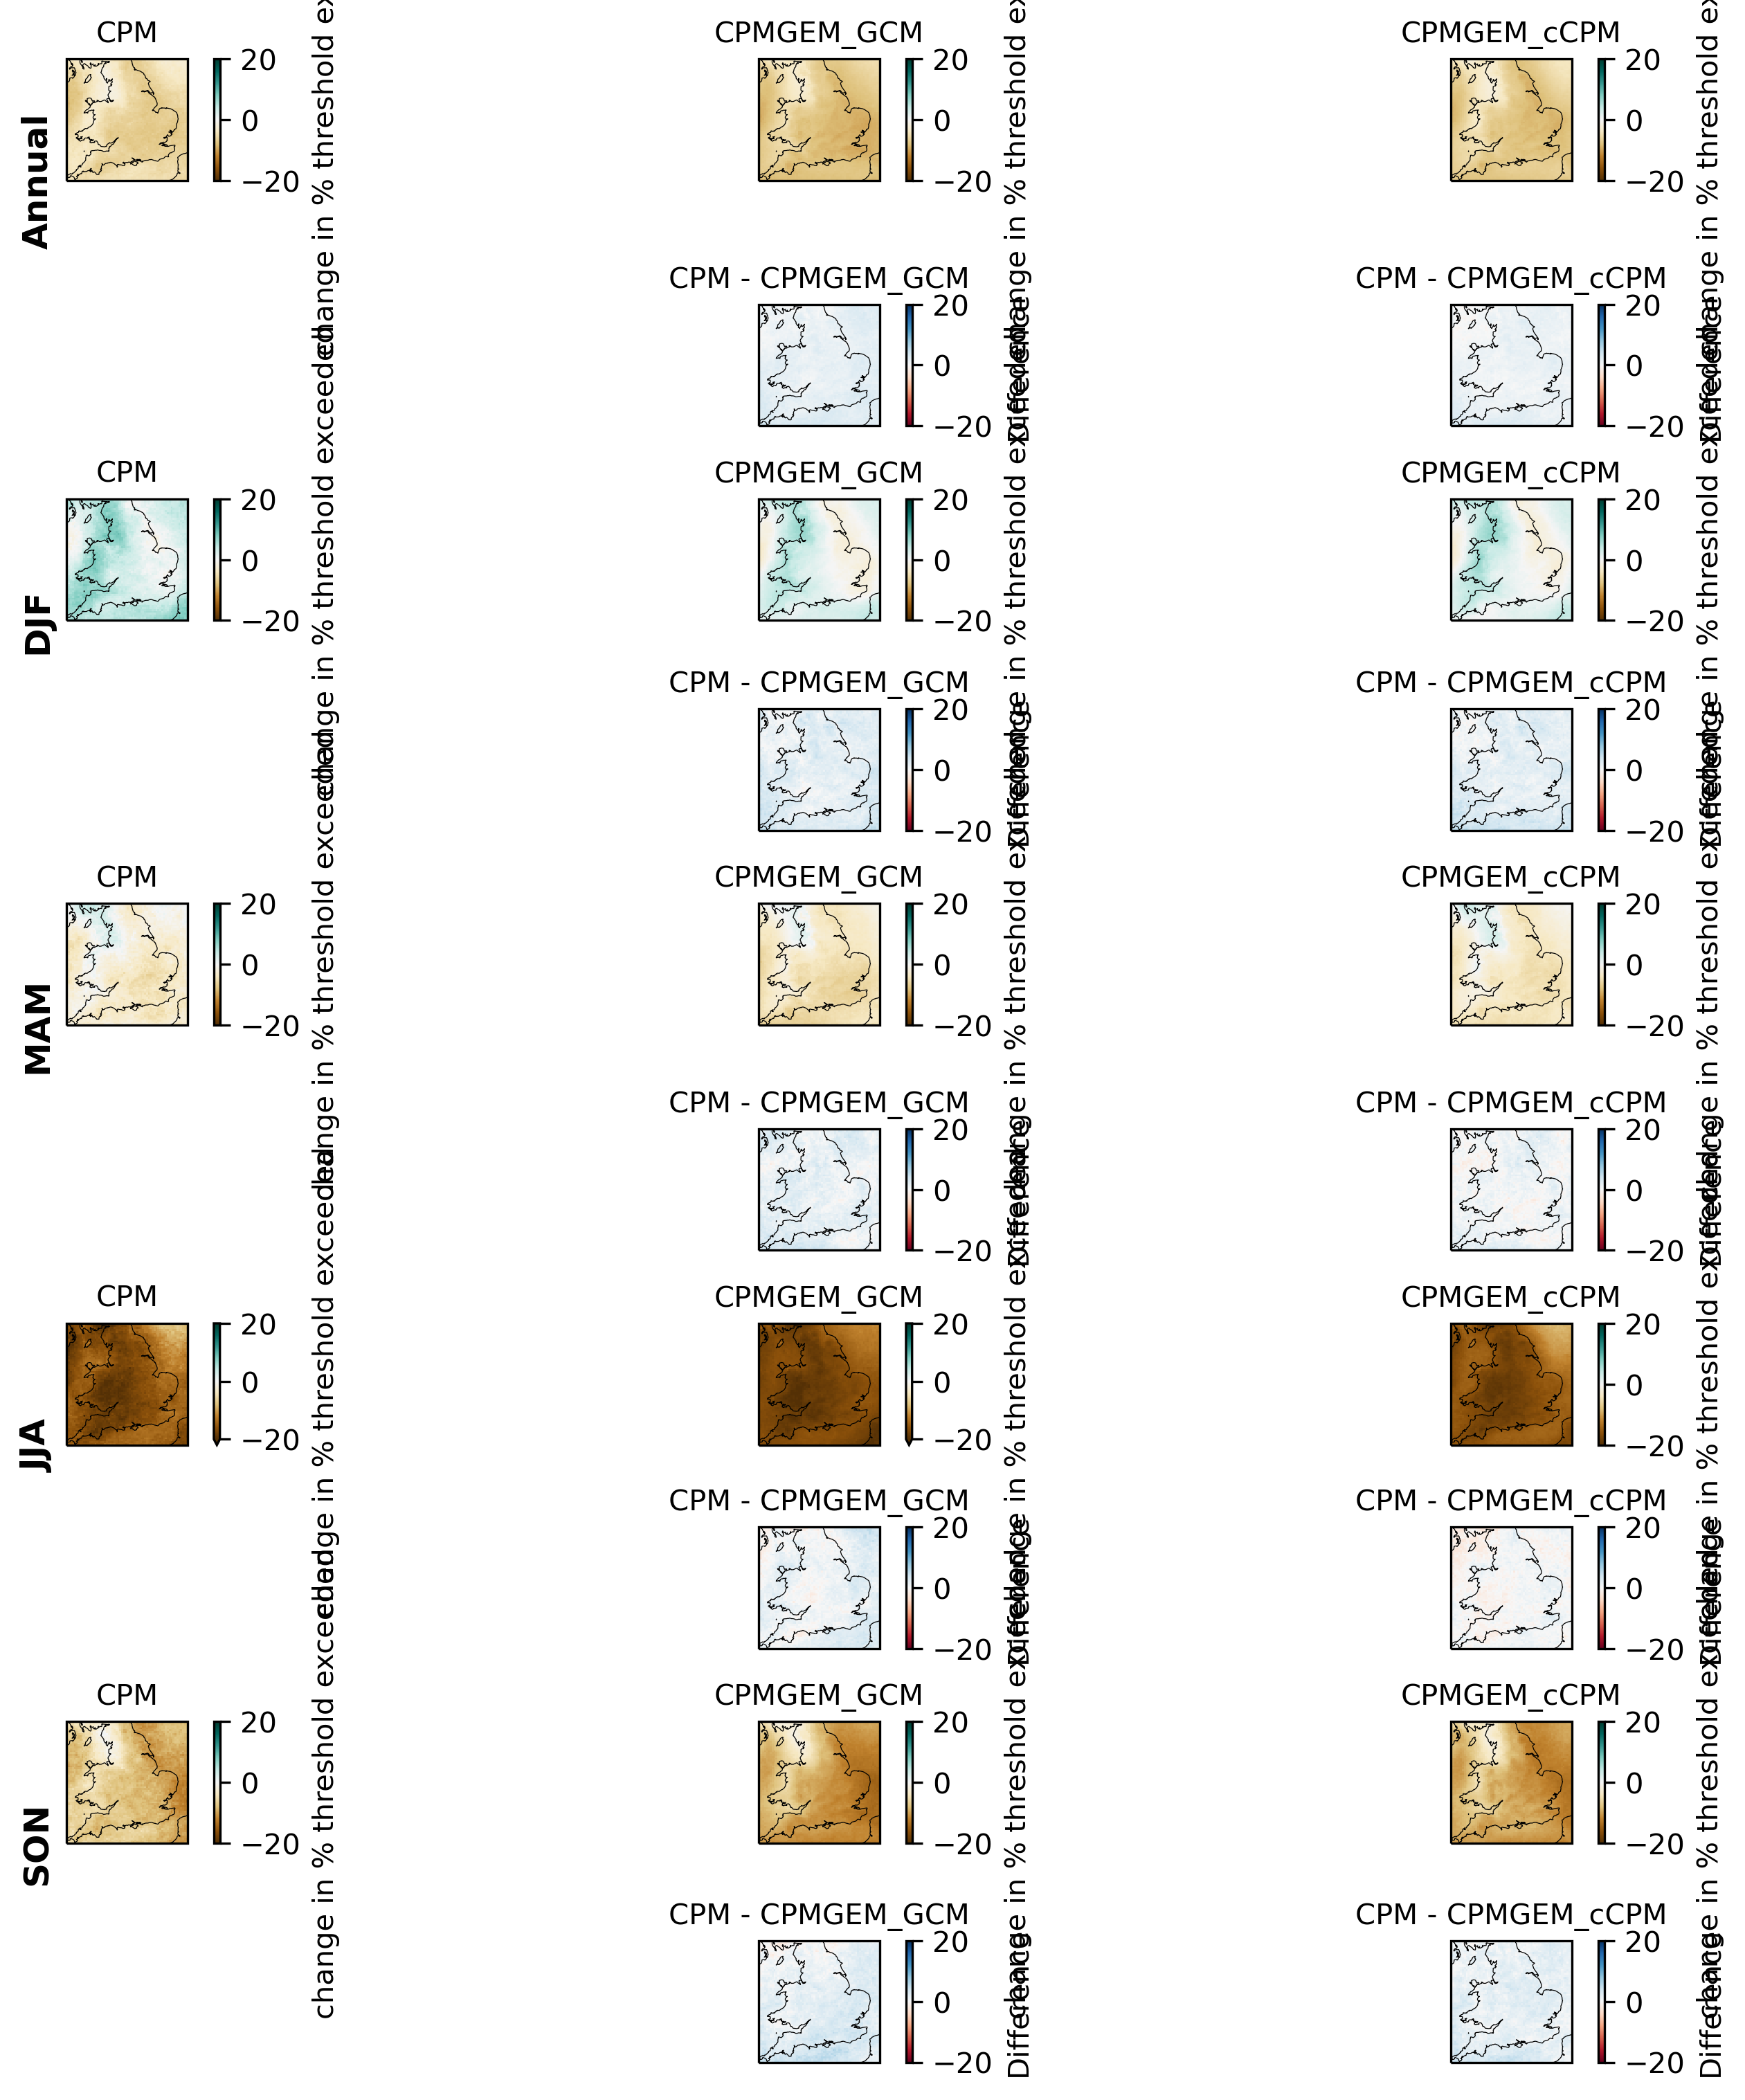

In [ ]:
change_stats = {    
    var: { 
        threshold: threshold_exceeded_prop_stats(CCS_DS[f"pred_{var}"], CPM_DAS[var], threshold=threshold, threshold_exceeded_prop_statistic=threshold_exceeded_prop_change) for threshold in thresholds
    } for var, thresholds in THRESHOLDS.items() if var in eval_vars
}

for var, thresholds in THRESHOLDS.items():
    if var in eval_vars:
        for threshold in thresholds:
            IPython.display.display_markdown(f"#### Threshold: {threshold}mm/day", raw=True)
            
            plot_threshold_exceedence_errors(change_stats[var][threshold][f"change in % threshold exceeded"], style="change")
        
            plt.show()

### CCS threshold exceedence frequency change: domain mean

In [ ]:
for var, thresholds in THRESHOLDS.items():
    if var not in eval_vars:
        continue
    for threshold in thresholds:
        pretty_table(
            change_stats[var][threshold].mean(dim=["grid_latitude", "grid_longitude"]),
            dim_order=["season", "model"],
            caption=f"{var} threshold: {threshold}{display.ATTRS[var]['units']}",
        )

pr threshold: 0.1mm/day 
 
 
   
   
 % Threshold exceeded (historic) 
 % Threshold exceeded (future) 
 change in % threshold exceeded 
 relative change in % threshold exceeded 
 
 
 season 
 model 
   
   
   
   
 
 
 
 
 Annual 
 CPMGEM_GCM 
 58.3 
 51.0 
 -7.2 
 -12.6 
 
 
 CPMGEM_cCPM 
 55.8 
 49.2 
 -6.6 
 -12.1 
 
 
 CPM 
 55.6 
 50.2 
 -5.5 
 -10.0 
 
 
 DJF 
 CPMGEM_GCM 
 68.0 
 69.5 
 1.5 
 2.1 
 
 
 CPMGEM_cCPM 
 66.3 
 67.8 
 1.5 
 2.1 
 
 
 CPM 
 66.3 
 69.9 
 3.6 
 5.3 
 
 
 MAM 
 CPMGEM_GCM 
 61.0 
 57.1 
 -3.9 
 -6.5 
 
 
 CPMGEM_cCPM 
 57.8 
 54.8 
 -3.0 
 -5.2 
 
 
 CPM 
 56.7 
 54.5 
 -2.2 
 -4.0 
 
 
 JJA 
 CPMGEM_GCM 
 46.1 
 29.3 
 -16.8 
 -37.5 
 
 
 CPMGEM_cCPM 
 44.0 
 28.4 
 -15.7 
 -36.6 
 
 
 CPM 
 43.9 
 28.3 
 -15.6 
 -36.4 
 
 
 SON 
 CPMGEM_GCM 
 58.0 
 48.3 
 -9.7 
 -17.1 
 
 
 CPMGEM_cCPM 
 55.2 
 45.9 
 -9.4 
 -17.4 
 
 
 CPM 
 55.6 
 48.0 
 -7.6 
 -14.0

### CCS wet-day mean intensity change: gridbox

#### Threshold: 0.1mm/day

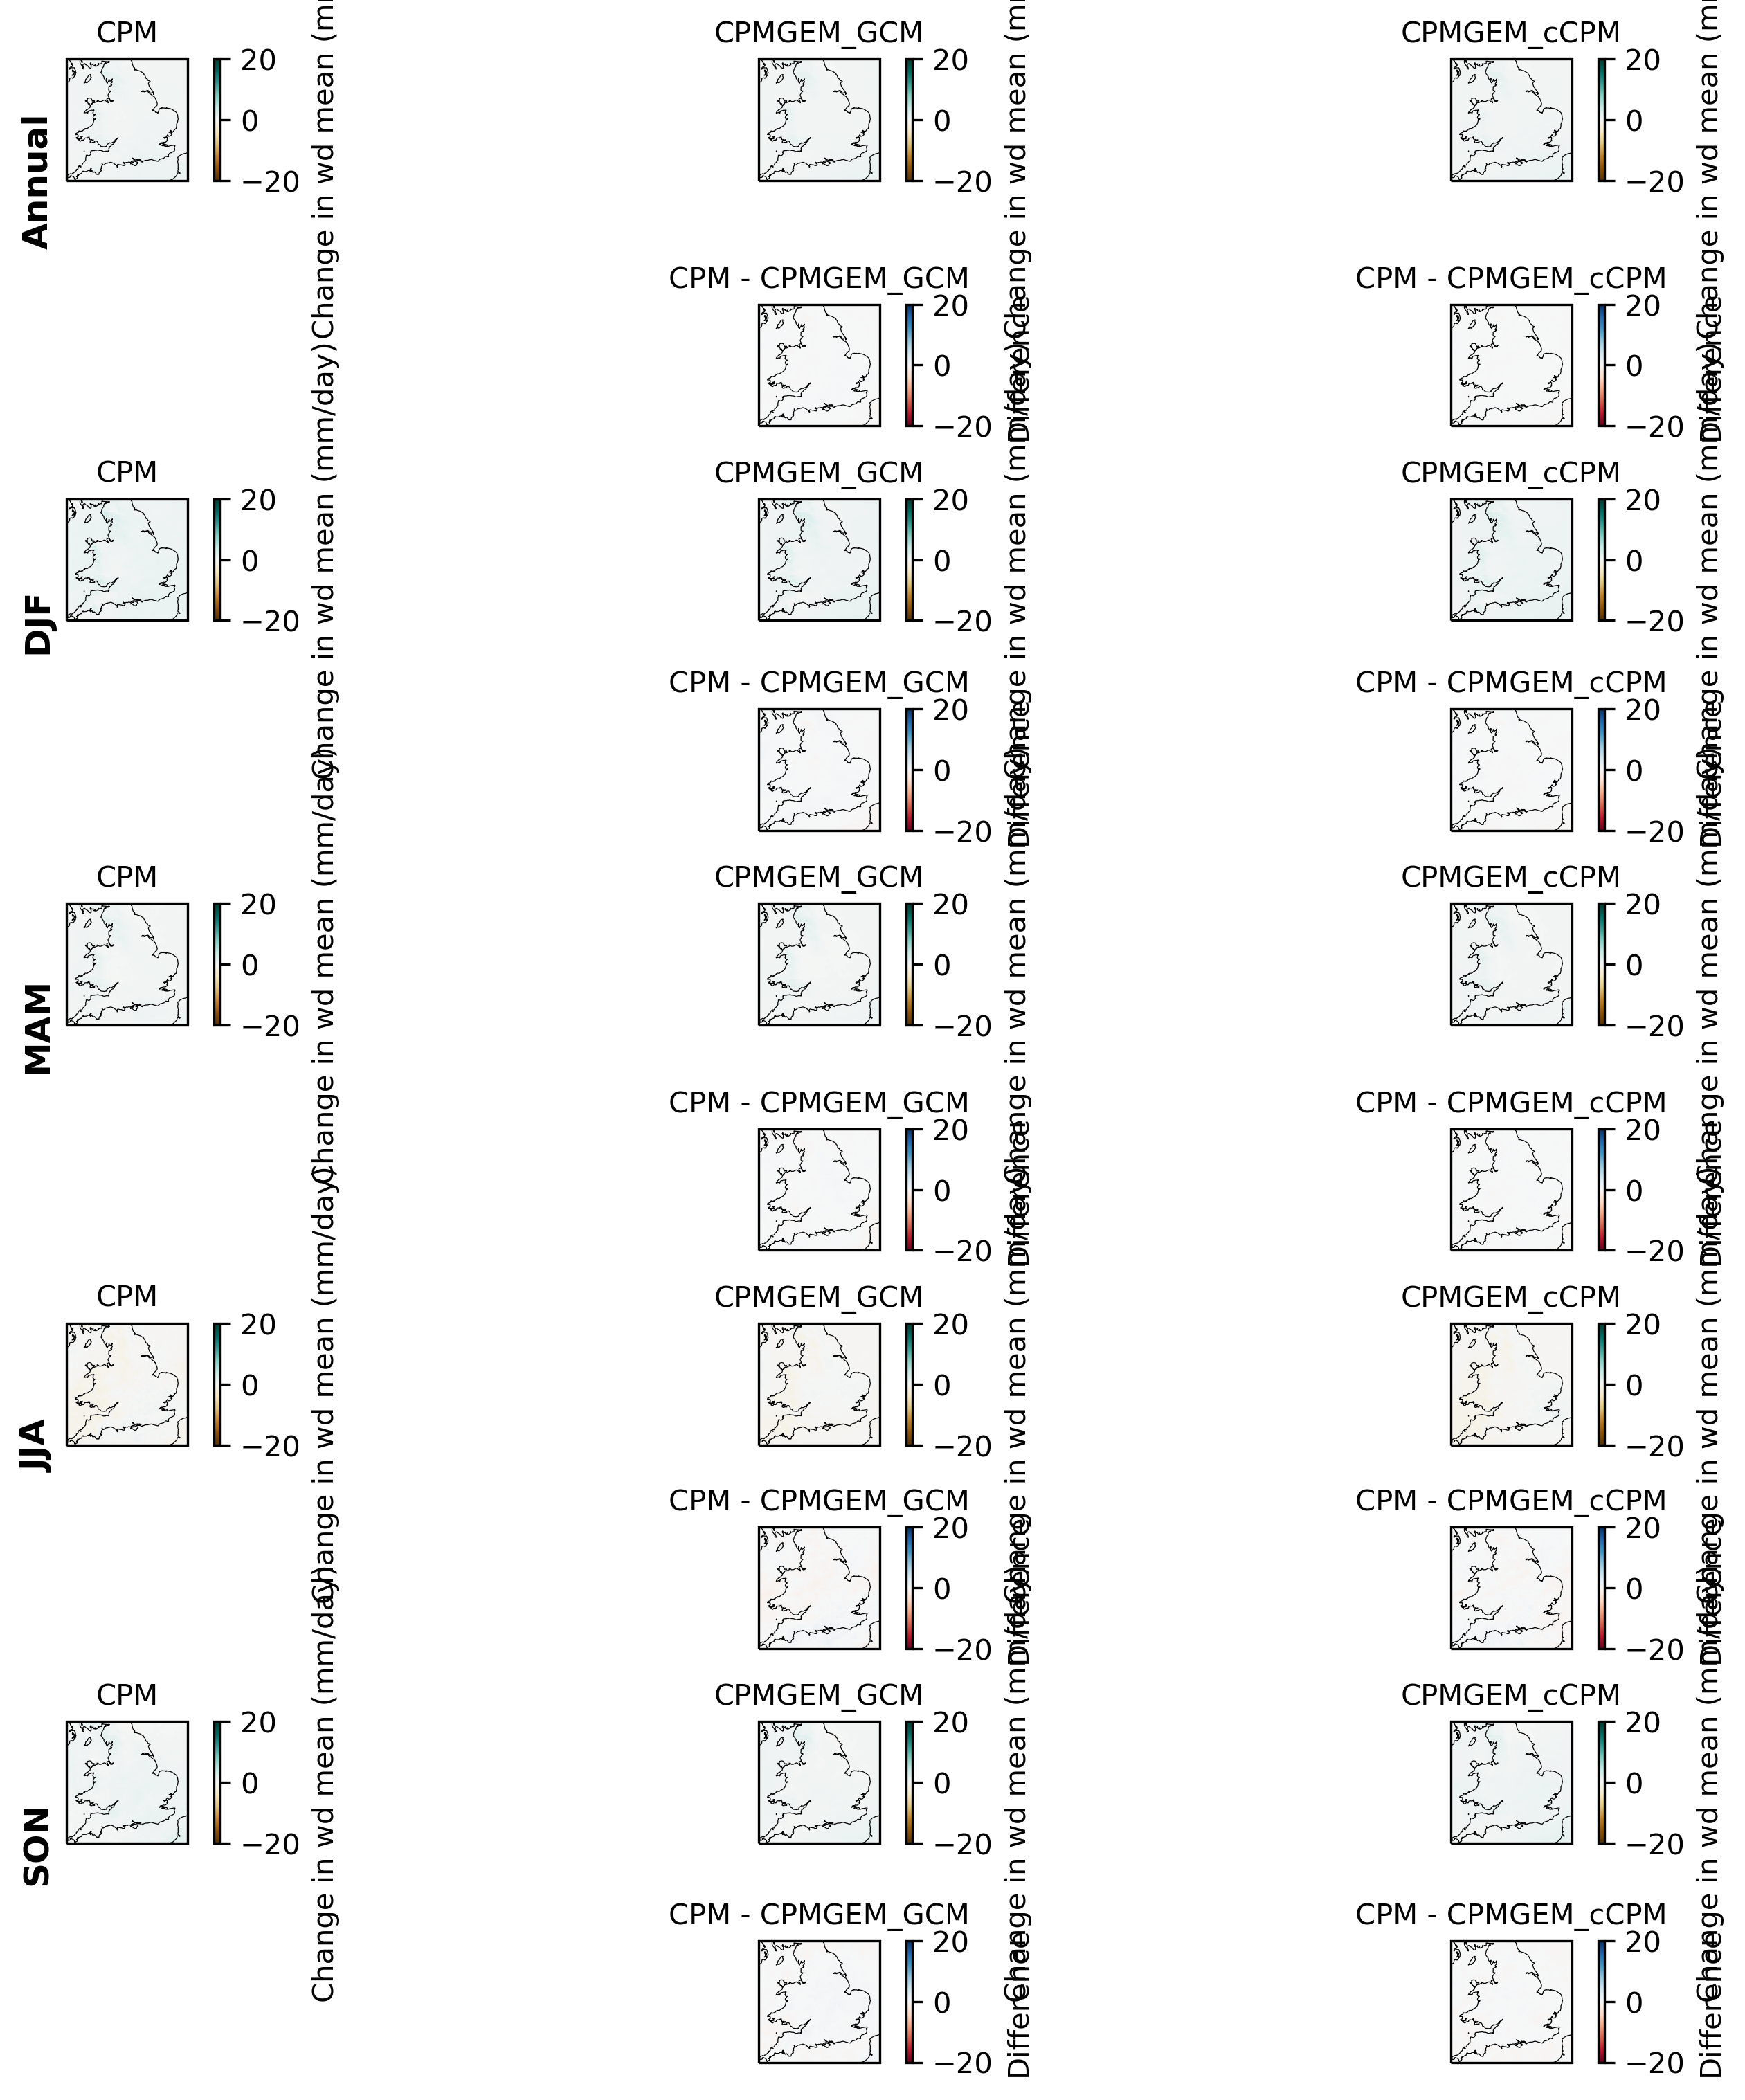

In [ ]:
model_das = {var: [
    EVAL_DS[source][f"pred_{var}"].sel(model=model)
    for source, mconfigs in MODELS.items() for model, spec in mconfigs.items()
] for var, thresholds in THRESHOLDS.items() if var in eval_vars}

change_stats = {    
    var: { 
        threshold: threshold_exceeded_prop_stats(CCS_DS[f"pred_{var}"], CPM_DAS[var], threshold=threshold, threshold_exceeded_prop_statistic=wd_mean_change) for threshold in thresholds
    } for var, thresholds in THRESHOLDS.items() if var in eval_vars
}


for var, thresholds in THRESHOLDS.items():
    if var in eval_vars:
        for threshold in thresholds:
            IPython.display.display_markdown(f"#### Threshold: {threshold}mm/day", raw=True)
            
            plot_threshold_exceedence_errors(change_stats[var][threshold][f"Change in wd mean (mm/day)"], style="change")
        
            plt.show()

In [ ]:
for var, thresholds in THRESHOLDS.items():
    if var not in eval_vars:
        continue
    for threshold in thresholds:
        pretty_table(
            change_stats[var][threshold].mean(dim=["grid_latitude", "grid_longitude"]).expand_dims({"threshold": [threshold], "variable": [var]}),
            dim_order=["variable", "threshold", "season", "model"],
            caption=f"{var} threshold: {threshold}{display.ATTRS[var]['units']}",
        )

pr threshold: 0.1mm/day 
 
 
   
   
   
   
 Historic wd mean (mm/day) 
 Future wd mean (mm/day) 
 Change in wd mean (mm/day) 
 
 
 variable 
 threshold 
 season 
 model 
   
   
   
 
 
 
 
 pr 
 0.100000 
 Annual 
 CPMGEM_GCM 
 4.4 
 4.8 
 0.4 
 
 
 CPMGEM_cCPM 
 4.4 
 4.9 
 0.5 
 
 
 CPM 
 4.5 
 5.0 
 0.5 
 
 
 DJF 
 CPMGEM_GCM 
 4.8 
 5.4 
 0.7 
 
 
 CPMGEM_cCPM 
 4.9 
 5.6 
 0.7 
 
 
 CPM 
 4.9 
 5.7 
 0.8 
 
 
 MAM 
 CPMGEM_GCM 
 3.9 
 4.2 
 0.3 
 
 
 CPMGEM_cCPM 
 3.8 
 4.2 
 0.4 
 
 
 CPM 
 3.7 
 4.1 
 0.4 
 
 
 JJA 
 CPMGEM_GCM 
 4.0 
 3.8 
 -0.3 
 
 
 CPMGEM_cCPM 
 4.2 
 4.0 
 -0.3 
 
 
 CPM 
 4.3 
 4.1 
 -0.3 
 
 
 SON 
 CPMGEM_GCM 
 4.7 
 5.2 
 0.4 
 
 
 CPMGEM_cCPM 
 4.7 
 5.2 
 0.6 
 
 
 CPM 
 4.9 
 5.4 
 0.5